In [1]:
%load_ext autoreload
%autoreload 2
import glob, sys
import numpy as np
import matplotlib.pyplot as plt
import time
from scipy.integrate import simps
import pyccl as ccl
import clmm
from clmm import Cosmology
def binning(corner): return [[corner[i],corner[i+1]] for i in range(len(corner)-1)]

In [2]:
clmm.__version__

'1.10.0'

In [3]:
%load_ext autoreload
%autoreload 2
import CL_COUNT_modeling_completeness as comp
import CL_COUNT_modeling_purity as pur
import CL_COUNT_modeling_halo_mass_function as hmf
import CL_COUNT_modeling_richness_mass_relation as rm_relation
import CL_MASS_cluster_mass as cl_mass
import CL_COUNT_cluster_abundance as cl_count
import CL_LENSING_cluster_lensing as cl_lensing

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Hyper-parameters
## Hyper-parameters (non-cosmo)

In [4]:
#cosmology
Omega_c_true = 0.30711 - 0.048254
Omega_b_true = 0.048254
sigma8_true = .8288
Omegam_true = 0.30711
True_value = [Omega_c_true + Omega_b_true, sigma8_true]
cosmo_clmm = Cosmology(H0 = 71.0, Omega_dm0 = 0.265 - 0.0448, Omega_b0 = 0.0448, Omega_k0 = 0.0)
cosmo = ccl.Cosmology(Omega_c = Omega_c_true, Omega_b = Omega_b_true, h = 0.6777, sigma8 = sigma8_true, n_s=0.96)
#halo model
massdef = ccl.halos.massdef.MassDef('vir', 'critical',)# c_m_relation=None)
hmd = ccl.halos.hmfunc.MassFuncDespali16( mass_def=massdef)

## Hyper-parameters (non-cosmo)

In [5]:
#purity
a_nc, b_nc, a_rc, b_rc = np.log(10)*0.8612, np.log(10)*0.3527, 2.2183, -0.6592
theta_purity = [a_nc, b_nc, a_rc, b_rc]
#completeness
a_nc, b_nc, a_mc, b_mc = 1.1321, 0.7751, 13.31, 0.2025
theta_completeness = [a_nc, b_nc, a_mc, b_mc]
#rm_relation
log10m0, z0 = np.log10(10**14.2), .4
proxy_mu0, proxy_muz, proxy_mulog10m =  3.091, 0, 1.05*np.log(10)
proxy_sigma0, proxy_sigmaz, proxy_sigmalog10m =  0.594, 0., 0.026*np.log(10)
theta_rm = [log10m0, z0, proxy_mu0, proxy_muz, proxy_mulog10m, proxy_sigma0, proxy_sigmaz, proxy_sigmalog10m]

# Purity

In [6]:
richness_grid = np.logspace(np.log10(2), np.log10(500), 310)
logm_grid = np.linspace(11, 16, 30)
z_grid = np.linspace(.1, 1, 301)

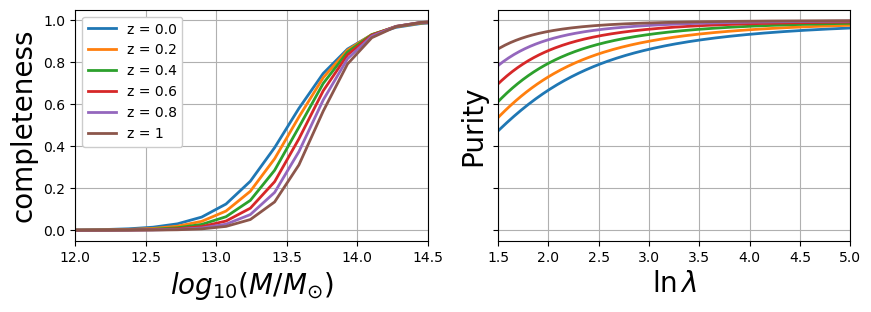

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(10, 3), sharey=True)
for z in [0., 0.2, 0.4, .6, .8, 1]:
    ax[1].plot(np.log(richness_grid), pur.purity(richness_grid, z, theta_purity), linewidth=2)
    ax[1].set_xlabel(r'$\ln \lambda$', fontsize=20)
    ax[1].set_ylabel('Purity', fontsize=20)
    ax[1].grid(True)
    ax[1].set_xlim(1.5, 5)
    ax[0].plot(logm_grid, comp.completeness(logm_grid, z, theta_completeness), linewidth=2, label = f'z = {z}')
    ax[0].set_xlabel(r'$log_{10}(M/M_{\odot})$', fontsize=20)
    ax[0].set_ylabel('completeness', fontsize=20)
    ax[0].set_xlim(12, 14.5)
    ax[0].grid(True)
    ax[0].legend(framealpha=1)
#plt.savefig('Purity_completeness.png', bbox_inches='tight', dpi=300)

# Richness-mass relation
$$
P(\log\lambda|M,z) = N(\mu(M,z), \sigma^2(M,z))
$$
the mean is
$$
\mu(M,z) = \mu_0 + a_\mu^M\log_{10}\frac{M}{M_0} + a_M^z\log_{10}\frac{1+z}{1+z_0} 
$$
variance is
$$
\sigma(M,z) = \sigma_0 + a_\sigma^M\log_{10}\frac{M}{M_0} + a_\sigma ^z\log_{10}\frac{1+z}{1+z_0} 
$$

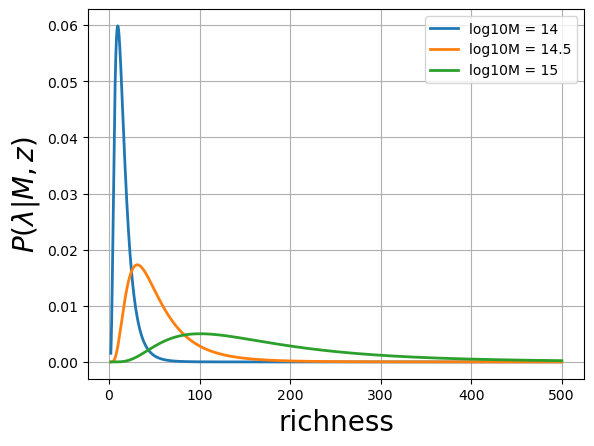

In [8]:
logm = [14, 14.5, 15]
for logm_ in logm:
    plt.plot(richness_grid, rm_relation.pdf_richness_mass_relation(richness_grid, logm_, 0, theta_rm), linewidth=2, label = 'log10M = {}'.format(logm_))
plt.xlabel('richness', fontsize=20)
plt.ylabel(r'$P(\lambda|M, z)$', fontsize=20)
plt.grid(True)
#plt.xscale('log')
plt.legend()

# Cluster Abundance

In [9]:
z_edges = np.linspace(0.1, 1, 4)
Z_bin = binning(z_edges)
richness_edges = np.exp(np.linspace(np.log(20), np.log(200), 5))
Richness_bin = binning(richness_edges)

## effect of purity and completeness

In [10]:
bins = {'redshift_bins':Z_bin, 'richness_bins': Richness_bin}
grids = {'logm_grid': logm_grid, 'z_grid': z_grid, 'richness_grid':richness_grid}
count_modelling = {'dNdzdlogMdOmega':None,'richness_mass_relation':None, 'completeness':None, 'purity':None }
params = {'params_purity':theta_purity, 'params_completeness': theta_completeness, 'params_richness_mass_relation': theta_rm,
         'CCL_cosmology': cosmo, 'halo_mass_distribution': hmd}
adds = {'add_purity' : True, 'add_completeness':True}
compute = {'compute_dNdzdlogMdOmega':True,'compute_richness_mass_relation':True, 'compute_completeness':True, 'compute_purity':True }

In [11]:
#compute_count_modeling
%time count_modelling_new = cl_count.recompute_count_modelling(count_modelling, grids = grids, compute = compute, params = params)

CPU times: user 5.04 s, sys: 148 ms, total: 5.19 s
Wall time: 1.34 s


In [12]:
print(count_modelling_new.keys())
print(compute)

dict_keys(['dNdzdlogMdOmega', 'richness_mass_relation', 'completeness', 'purity', 'richness_mass_relation - mean', 'richness_mass_relation - sigma'])
{'compute_dNdzdlogMdOmega': True, 'compute_richness_mass_relation': True, 'compute_completeness': True, 'compute_purity': True}


In [13]:
#define integrand
integrand_count = cl_count.define_count_integrand(count_modelling_new, adds)

In [14]:
Omega = (4*np.pi)
N = Omega * cl_count.Cluster_SurfaceDensity_ProxyZ(bins, integrand_count = integrand_count, grids = grids)

In [15]:
adds1 = {'add_purity' : False, 'add_completeness':False}
adds2 = {'add_purity' : True, 'add_completeness':False}
adds3 = {'add_purity' : False, 'add_completeness':True}
adds4 = {'add_purity' : True, 'add_completeness':True}
adds_list = [adds1, adds2, adds3, adds4]
list_dNdlambda = []
for adds in adds_list:
    integrand_count = cl_count.define_count_integrand(count_modelling_new, adds)
    list_dNdlambda.append(simps(integrand_count, logm_grid, axis=1))

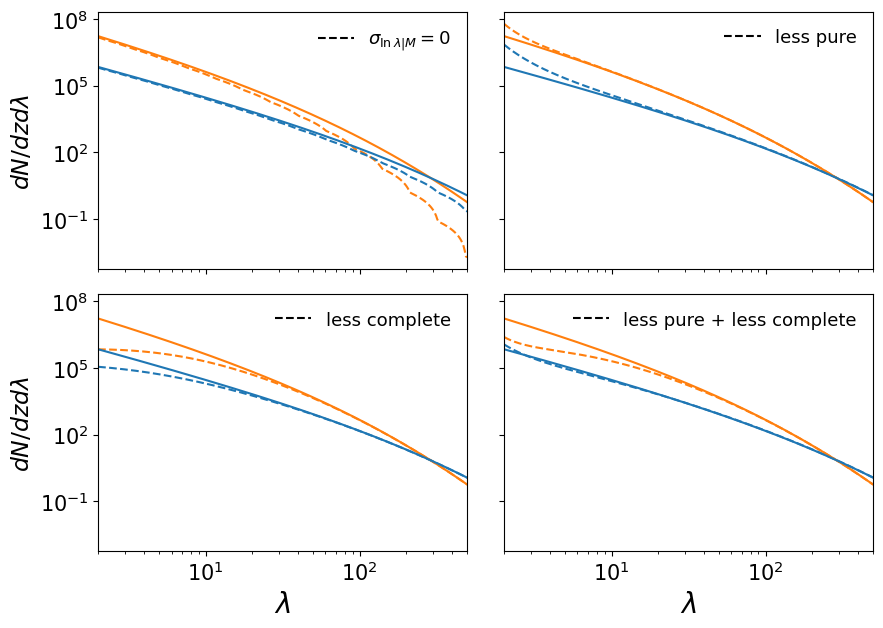

In [16]:
fig, ax = plt.subplots(2,2, figsize=(10,7), sharex=True, sharey=True, )
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.1, hspace=0.1)
fmt = ['-', '-', '-', '-']
p0m = hmf.dndlog10M(logm_grid, z_grid[299], cosmo, hmd)*hmf.dVdzdOmega(z_grid[299], cosmo)
log10Mlambda = log10m0 + np.log(richness_grid/np.exp(proxy_mu0))/proxy_mulog10m + (proxy_muz/proxy_mulog10m) * np.log((1+z_grid[299])/(1 + z0))
newhmf = np.interp(log10Mlambda, logm_grid, p0m)

ax[0,0].plot(richness_grid, Omega*newhmf/(proxy_mulog10m*richness_grid), '--C1')
ax[0,1].plot(richness_grid, Omega*list_dNdlambda[1][:,299], '--C1')
ax[1,0].plot(richness_grid, Omega*list_dNdlambda[2][:,299], '--C1')
ax[1,1].plot(richness_grid, Omega*list_dNdlambda[3][:,299], '--C1')

ax[0,0].plot([], [], '--k', label = r'$\sigma_{\ln\lambda|M} = 0$')
ax[0,1].plot([], [], '--k',  label = 'less pure')
ax[1,0].plot([], [], '--k',  label = 'less complete')
ax[1,1].plot([], [], '--k', label = 'less pure + less complete')



p0m = hmf.dndlog10M(logm_grid, z_grid[0], cosmo, hmd)*hmf.dVdzdOmega(z_grid[0], cosmo)
log10Mlambda = log10m0 + np.log(richness_grid/np.exp(proxy_mu0))/proxy_mulog10m + (proxy_muz/proxy_mulog10m) * np.log((1+z_grid[0])/(1 + z0))
newhmf = np.interp(log10Mlambda, logm_grid, p0m)

ax[0,0].plot(richness_grid, Omega*newhmf/(proxy_mulog10m*richness_grid), '--C0')
ax[0,1].plot(richness_grid, Omega*list_dNdlambda[1][:,0], '--C0',  )
ax[1,0].plot(richness_grid, Omega*list_dNdlambda[2][:,0], '--C0', )
ax[1,1].plot(richness_grid, Omega*list_dNdlambda[3][:,0], '--C0', )
plt.loglog()
for i in range(2):
    for j in range(2):
        ax[i,j].plot(richness_grid, Omega*list_dNdlambda[0][:,299], '-C1')
        ax[i,j].plot(richness_grid, Omega*list_dNdlambda[0][:,0], '-C0')
        ax[i,j].set_xscale('log')
        ax[i,j].set_yscale('log')
        ax[i,j].set_xlim(min(richness_grid), max(richness_grid))
       # ax[i,j].set_ylim(1e-1, 1e9)
        ax[i,j].legend(frameon=False, fontsize=13, loc = 'upper right')
        if j ==0:
            ax[i,j].set_ylabel(f'$dN/dzd\lambda$', fontsize=17)
        if i ==1:
            ax[i,j].set_xlabel('$\lambda$', fontsize=20)
        ax[i,j].tick_params(axis='both', which="both", labelsize= 15)
#plt.tick_params(axis='both', which="both", labelsize= 20)
#plt.savefig('hlambdaf.png', bbox_inches='tight', dpi=300)